In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from tensorflow.keras import models, layers

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
import time

2024-11-24 16:25:34.492952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732494334.530548  687092 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732494334.541575  687092 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 16:25:34.586805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [174]:
def load_data():
    df = pd.read_csv('cluster_data/train_workloads_final_10_clusters.csv')
    
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]

    print(feature_cols)

    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y.values

def load_test_data():
    df = pd.read_csv('cluster_data/test_workloads_final_10_clusters.csv')
  
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]
    print(feature_cols)

    
    target_cols = ['db2', 'actual']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    return X, Y

def my_validation_curve(estimator_name, estimator, param_name, param_range):
    train_scores, valid_scores = validation_curve(estimator, X, y, param_name=param_name,
        param_range=param_range, cv=10, scoring="neg_mean_squared_error",
    )

    train_scores = np.sqrt(np.abs(train_scores))
    valid_scores = np.sqrt(np.abs(valid_scores))
    
    print(len(train_scores))
    print(len(valid_scores))

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    title_str = "Validation Curve with " + estimator_name
    plt.title(title_str)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.plot(param_range, train_scores_mean, label="train rmse")
    plt.plot(param_range, valid_scores_mean, label="validation rmse")

    plt.legend(loc='lower right')
    plt.show()
    
    train_rmse = [round(elem, 2) for elem in train_scores_mean]
    valid_rmse = [round(elem, 2) for elem in valid_scores_mean]
    
    df_scores = pd.DataFrame({'param': param_range, 'train_rmse': train_rmse, 'valid_rmse': valid_rmse})
    print(df_scores)
    
def cross_validate(model):
    # Load data
    X, y = load_data()
    train_data = X.copy()
    train_targets = y.copy()

    k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    print('train rmse ', np.sqrt(np.mean(all_train_scores)))
    print('validation rmse ', np.sqrt(np.mean(all_scores)))

In [175]:
# Load data
X, y = load_data()

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)


# Ridge Cross-validate

In [176]:
ridge = Ridge(
        fit_intercept=True, 
        solver='lsqr',
        alpha = 1.0,
        random_state=42)

cross_validate(ridge)
ridge.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  118.25803405359572
validation rmse  125.87296130520568


Ridge(random_state=42, solver='lsqr')

# Decision Tree Regression - Tuning max_features

In [177]:
tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=0.23,
    random_state=33,
)

cross_validate(tree)

tree.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  209.60954302626592
validation rmse  214.68490457150622


DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.23, min_samples_split=4,
                      random_state=33)

# Forest final model - using tuned HP from AutoAI

In [178]:
forest = RandomForestRegressor(
    max_depth=5,
    max_features=0.6109469920813564,
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=17,
    #n_jobs=CPU_NUMBER,
    random_state=33,
)

cross_validate(forest)

forest.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was

Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  120.56034857693943
validation rmse  145.09790875731585


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was

RandomForestRegressor(max_depth=5, max_features=0.6109469920813564,
                      min_samples_leaf=4, min_samples_split=5, n_estimators=17,
                      random_state=33)

# XGB Regressor 

In [179]:
# this is from AutoAI run on Feb 8, 2022
xgb_regressor = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=0.1814227666290778,
    max_delta_step=0,
    max_depth=1,
    min_child_weight=2,
    missing=float("nan"),
    monotone_constraints="()",
    n_estimators=879,
    num_parallel_tree=1,
    random_state=33,
    reg_alpha=1,
    reg_lambda=0.40529327440922186,
    scale_pos_weight=1,
    subsample=0.04694370939809412,
    tree_method="exact",
    validate_parameters=1,
    verbosity=0,
    silent=False,
    nthread=1,
    seed=33,
)

cross_validate(xgb_regressor)

xgb_regressor.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  127.08870427888459
validation rmse  155.22115101101872


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy=None, importance_type=None, interaction_constraints='',
             learning_rate=0.1814227666290778, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=1, max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints='()', multi_strategy=None, n_estimators=879,
             n_jobs=None, nthread=1, ...)

# Deep Neural Network (DNN)

In [180]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0
Processing fold #1


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2
Processing fold #3


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4
Processing fold #5


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6
Processing fold #7


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8
Processing fold #9


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  118.25369051831726
validation rmse  125.94542900298954


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=100,
             random_state=6, solver='lbfgs')

# DNN - solver='lbfgs'

In [181]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5
Processing fold #6


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  118.25369051831726
validation rmse  125.94542900298954


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=100,
             random_state=6, solver='lbfgs')

# DNN - epochs = 150

In [182]:
dnn_model = dnn_model = MLPRegressor(max_iter=150,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5
Processing fold #6


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  118.25369051831726
validation rmse  125.94542900298954


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=150,
             random_state=6, solver='lbfgs')

# DNN - activation=tanh

In [183]:
dnn_model = dnn_model = MLPRegressor(max_iter=150,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  118.25369051831726
validation rmse  125.94542900298954


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=150,
             random_state=6, solver='lbfgs')

# DNN - Relu

In [184]:
dnn_model = dnn_model = MLPRegressor(max_iter=100,
                     alpha=0.001,
                     #activation='identity',
                     activation='relu',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']
X.shape:  (186, 10)
y.shape:  (186, 1)
Processing fold #0


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #6


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #7


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #8


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #9


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train rmse  75.0083489867167
validation rmse  144.69651010549035


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.001, hidden_layer_sizes=(48, 39, 27, 16, 7, 5),
             max_iter=100, random_state=6, solver='lbfgs')

# All Models Summary

In [185]:
models = [ridge, tree, forest, xgb_regressor, dnn_model]

In [186]:
X_test, Y_test = load_test_data()

['cluster_0.0', 'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0', 'cluster_5.0', 'cluster_6.0', 'cluster_7.0', 'cluster_8.0', 'cluster_9.0']


In [187]:
X_test.shape

(46, 10)

In [188]:
Y_test.shape

(46, 2)

## Computing Inference Latency

In [189]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    tree.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

tree_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('tree: ', tree_time, ' μs')

tree:  287.6  μs


In [190]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    forest.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

forest_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('forest: ', forest_time, ' μs')

forest:  3266.2  μs


In [191]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    xgb_regressor.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

xgb_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('xgb: ', xgb_time, ' μs')

xgb:  994.3  μs


In [192]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    ridge.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

ridge_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('ridge: ', ridge_time, ' μs')

ridge:  196.2  μs


In [193]:
latency_sum = 0
for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    dnn_model.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

dnn_time = np.round(latency_sum / X_test.shape[0] * 1000000, 1)

print('dnn: ', dnn_time, ' μs')

dnn:  215.3  μs


## Generating Predictions

In [194]:
Y_test['tree'] = tree.predict(X_test.values)
Y_test['forest'] = forest.predict(X_test.values)
Y_test['xgb'] = xgb_regressor.predict(X_test.values)
Y_test['ridge'] = ridge.predict(X_test.values)
Y_test['dnn'] = dnn_model.predict(X_test.values)

In [195]:
Y_test.head()

,db2,actual,tree,forest,xgb,ridge,dnn
0,3258.236,1829.644,1718.189891,1661.676189,1696.140381,1681.308580,1807.969326
1,4080.312,1321.968,1394.792861,1309.480860,1143.221069,1218.809712,1161.681195
2,4004.024,1187.164,1394.792861,1374.577702,1310.749268,1286.453164,1199.824753
3,3821.488,1456.636,1394.792861,1432.937518,1327.405518,1364.126288,1298.970942
4,4451.568,1162.852,1394.792861,1131.966857,1032.232422,1118.286615,900.044513


In [196]:
Y_test = Y_test[['actual', 'db2', 'tree', 'forest', 'xgb', 'ridge', 'dnn']]

In [197]:
from sklearn.metrics import mean_squared_error

def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict

In [198]:
rmse(Y_test)

{'db2': 2216.0,
 'tree': 224.0,
 'forest': 136.0,
 'xgb': 122.0,
 'ridge': 99.0,
 'dnn': 130.0}

In [199]:
print('TEST RMSE')
rmse(Y_test)

TEST RMSE


{'db2': 2216.0,
 'tree': 224.0,
 'forest': 136.0,
 'xgb': 122.0,
 'ridge': 99.0,
 'dnn': 130.0}

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[10,3])
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=13)
    #plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    #ax.xaxis.set_ticks_position('both')
    #ax.set_yticks(yticks_new)
    #plt.setp(ax.get_yticklabels(), rotation=45)
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

    plt.rc('font', **font)
    
    f.tight_layout()
    
    plt.savefig('job_workload_boxplot.png', dpi=150)

In [201]:
box_plot_title = 'Memory Estimation Error (MB)'

BOX PLOT


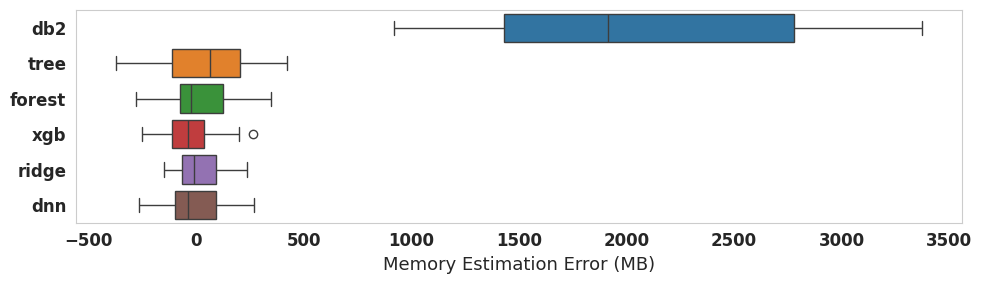

In [202]:
print('BOX PLOT')
box_plot(Y_test)

In [203]:
residuals = calculate_residuals(Y_test)

In [204]:
np.percentile(residuals['db2'], [25, 75])

array([1429.142, 2780.286])

In [205]:
np.percentile(residuals['ridge'], [25, 75])

array([-63.68937773,  90.76064221])

In [206]:
np.percentile(residuals['tree'], [25, 75])

array([-113.06810909,  202.56786076])

In [207]:
np.percentile(residuals['forest'], [25, 75])

array([-72.49056901, 126.24266944])

In [208]:
np.percentile(residuals['xgb'], [25, 75])

array([-112.79137939,   35.73986108])

In [209]:
np.percentile(residuals['dnn'], [25, 75])

array([-95.33119238,  91.29391935])

In [210]:
np.mean(Y_test['actual'])

1460.2333913043478

In [211]:
Y_test.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,1829.644,3258.236,1718.189891,1661.676189,1696.140381,1681.308580,1807.969326
1,1321.968,4080.312,1394.792861,1309.480860,1143.221069,1218.809712,1161.681195
2,1187.164,4004.024,1394.792861,1374.577702,1310.749268,1286.453164,1199.824753
3,1456.636,3821.488,1394.792861,1432.937518,1327.405518,1364.126288,1298.970942
4,1162.852,4451.568,1394.792861,1131.966857,1032.232422,1118.286615,900.044513


In [212]:
np.mean(Y_test)

1765.256014211411

# Models size

In [213]:
import sys
import pickle

In [214]:
# size of the ridge model
p = pickle.dumps(ridge)
print('Ridge:', sys.getsizeof(p) / 1024)

# size of the tree model
p = pickle.dumps(tree)
print('Decision Tree:', sys.getsizeof(p) / 1024)

# size of the forest model
p = pickle.dumps(forest)
print('Random Forest:', sys.getsizeof(p) / 1024)

# size of the xgboost model
p = pickle.dumps(xgb_regressor)
print('XGBoost:', sys.getsizeof(p) / 1024)

# size of the dnn model
p = pickle.dumps(dnn_model)
print('DNN:', sys.getsizeof(p) / 1024)

Ridge: 0.6064453125
Decision Tree: 1.4150390625
Random Forest: 40.7763671875
XGBoost: 655.169921875
DNN: 36.474609375


# Training Time

In [215]:
latency_sum = 0

for i in range(5):
    time_start = time.time()
    ridge.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('ridge training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    tree.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('tree training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    forest.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('forest training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    xgb_regressor.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('xgb training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    dnn_model.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('dnn training time: ', train_time, ' ms')

ridge training time:  3.2  ms
tree training time:  1.5  ms
forest training time:  33.6  ms


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was

xgb training time:  226.0  ms


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

dnn training time:  284.8  ms


/home/shaikhq/research/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [216]:
calculate_residuals(Y_test).to_csv('job-workload-residuals.csv')